#  Прогнозирование заказов такси

Для компании агрегатора такси нужно спрогнозировать количество заказов такси на следующий час (на основе исторических данных о заказах такси в аэропортах).

**Цель исследования** - построить модель для предсказания количества заказов такси на следующий час, со значением метрики *RMSE* на тестовой выборке не больше 48.

**Ход исследования**:
1. Загрузка и предобработка данных.
2. Анализ данных, добавление признаков.
3. Обучение моделей.
4. Тестирование моделей.
5. Общий вывод.

**Описание данных**

Предоставлен датасет с двумя столбцами:
* datetime - дата и время с интервалом 10 минут;
* num_orders - количество заказов такси за период.

## Загрузка и обзор данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.mode.chained_assignment = None

In [2]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(taxi.head())
display(taxi.describe())
taxi.info()

print('\nПроверка на монотонность:', taxi.index.is_monotonic)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.00
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Проверка на монотонность: True


**Выводы**
* Данные содержат только один признак, тип - integer;
* Пропусков в данных нет, судя по медианному и среднему значению, распределение стремится к нормальному;
* Индекс проверен на монотонность, шаг по времени в индексе - 10 минут.

## Анализ данных

Выполним ресемплирование данных по одному часу.

In [4]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Далее необходимо добавить в датасет новые признаки: календарные, скользящие и отстающие значения. Для этого сначала выполним анализ данных, оценим тренд, сезонность и остаток, построим графики.

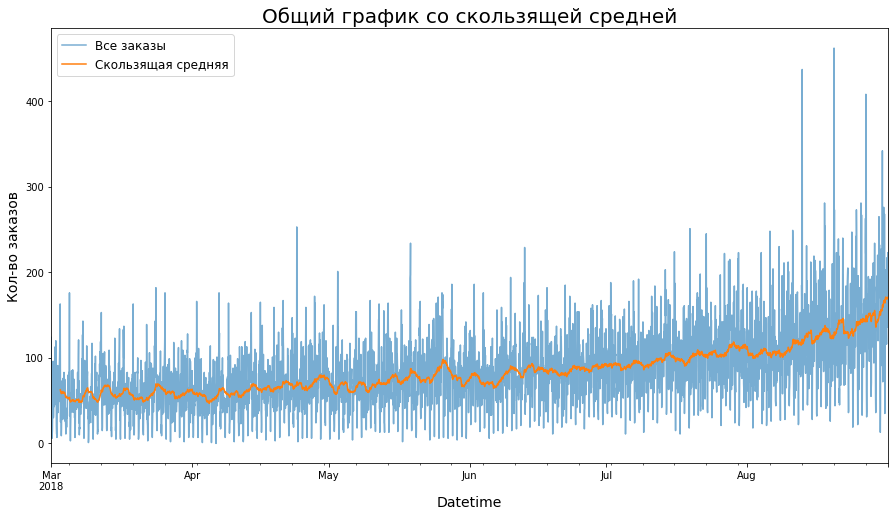

In [5]:
taxi.plot(figsize=(15, 8), alpha=0.6)
taxi.rolling(50).mean().plot(ax=plt.gca())
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Общий график со скользящей средней', fontsize=20)
plt.legend(['Все заказы', 'Скользящая средняя'], fontsize=12)
plt.show()

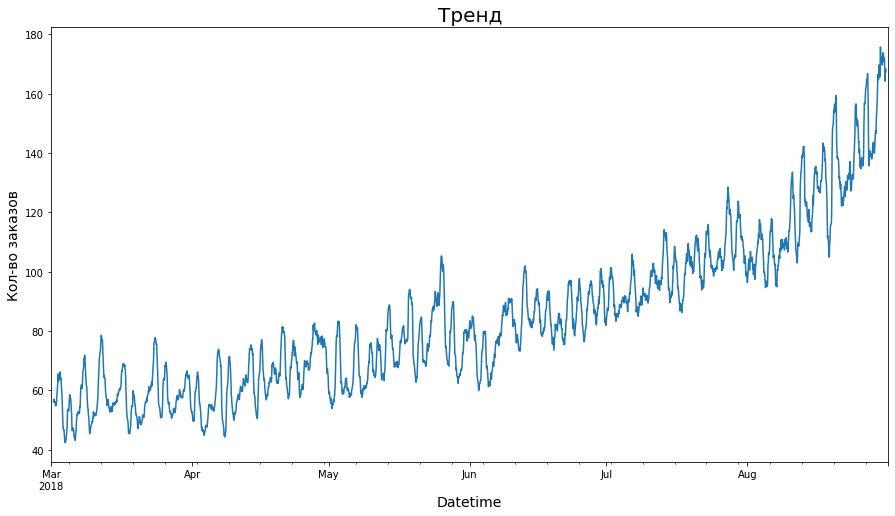

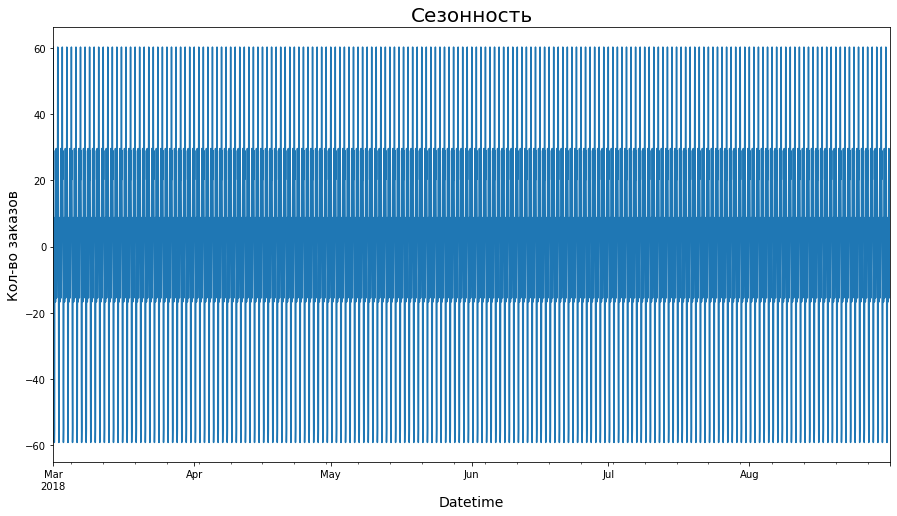

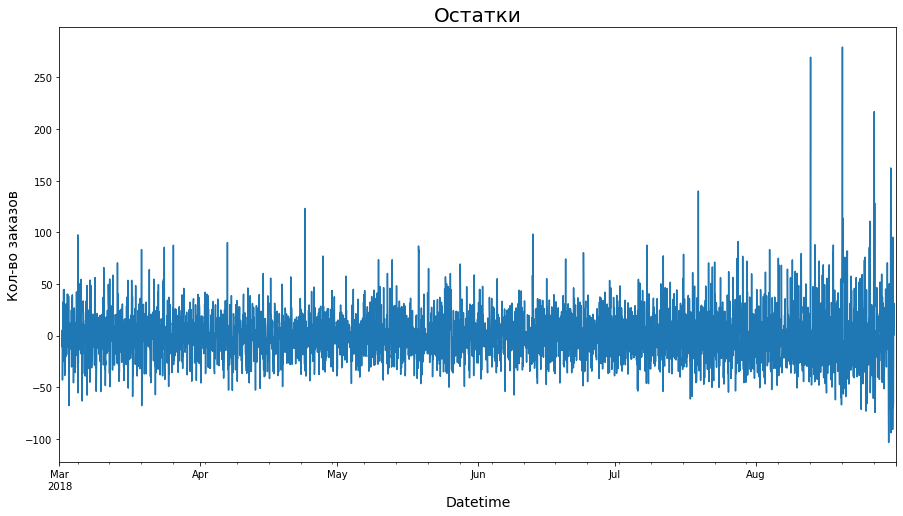

In [6]:
taxi_decomposed = seasonal_decompose(taxi)
taxi_decomposed.trend.plot(figsize=(15, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Тренд', fontsize=20)
plt.show()
taxi_decomposed.seasonal.plot(figsize=(15, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Сезонность', fontsize=20)
plt.show()
taxi_decomposed.resid.plot(figsize=(15, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Остатки', fontsize=20)
plt.show()

Для более наглядного представления рассмотрим в таком же срезе две последние недели августа.

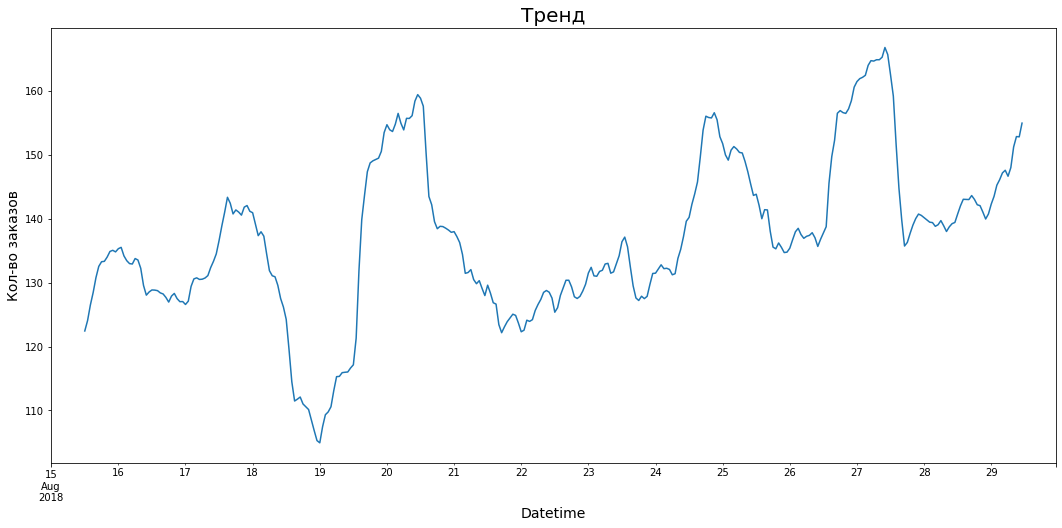

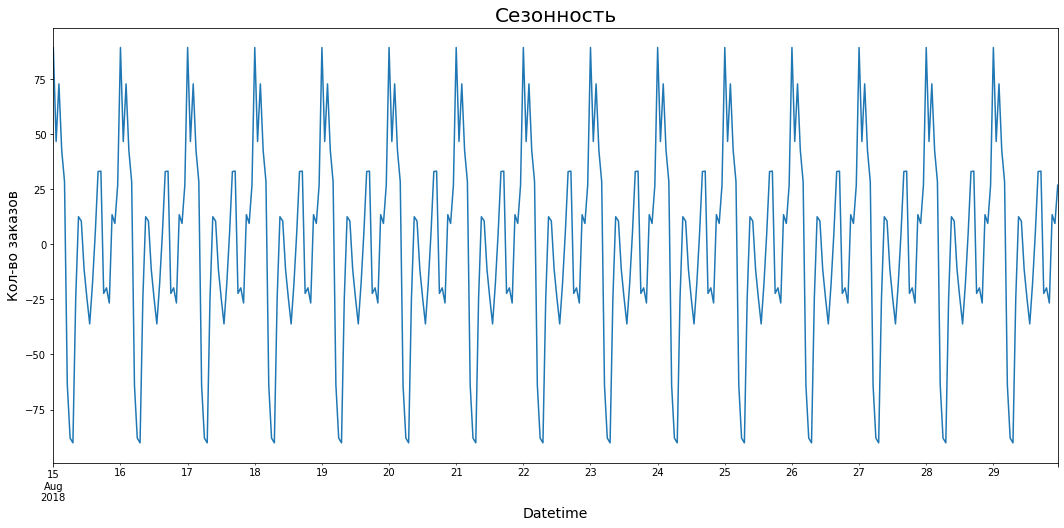

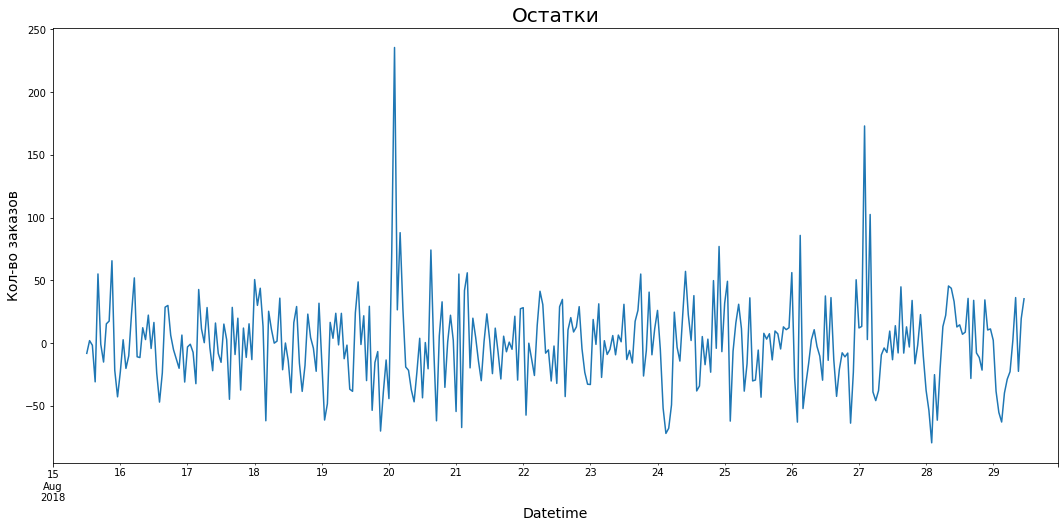

In [7]:
taxi_decomposed_month = seasonal_decompose(taxi['2018-08-15':'2018-08-29'])
taxi_decomposed_month.trend.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Тренд', fontsize=20)
plt.show()
taxi_decomposed_month.seasonal.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Сезонность', fontsize=20)
plt.show()
taxi_decomposed_month.resid.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Остатки', fontsize=20)
plt.show()

Также рассмотрим поближе другой промежуток из середины датасета, в конце июня.

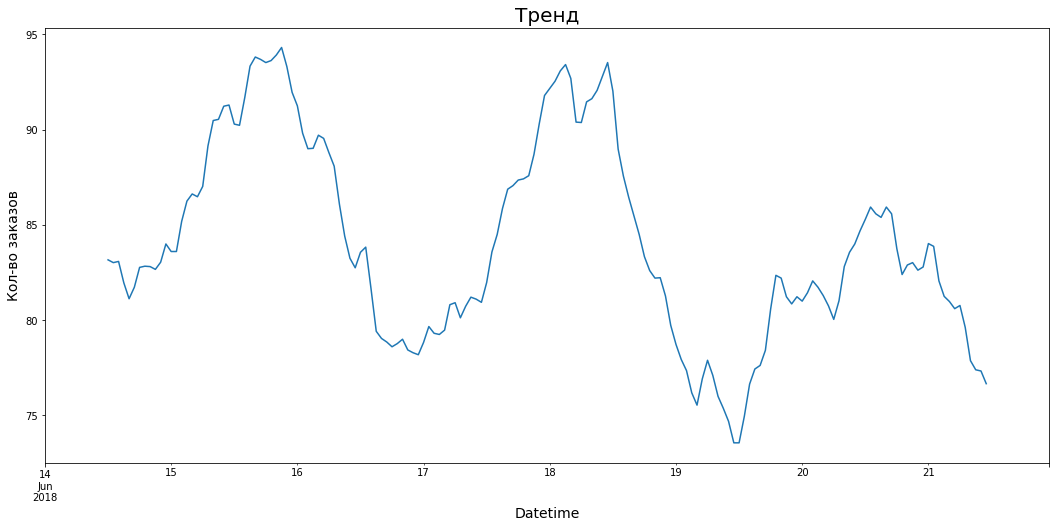

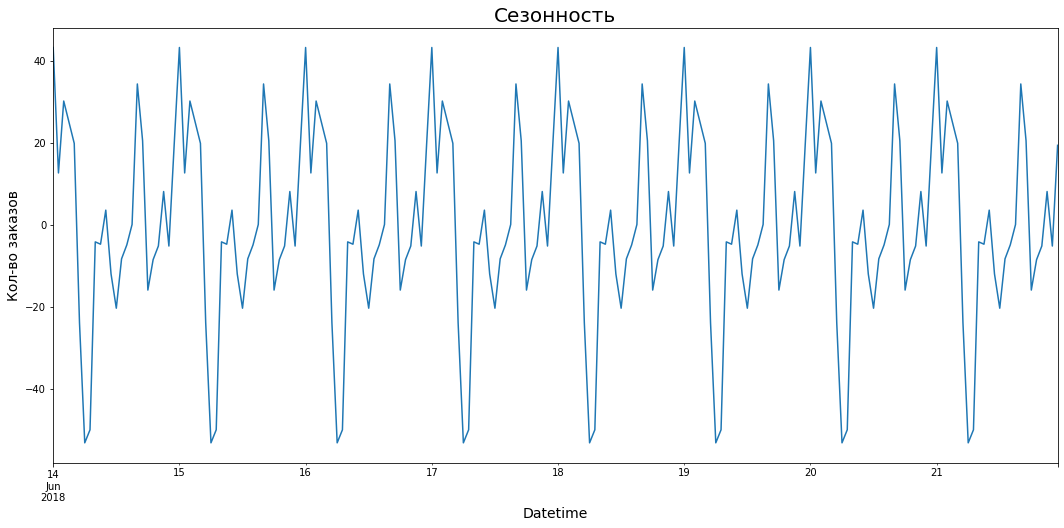

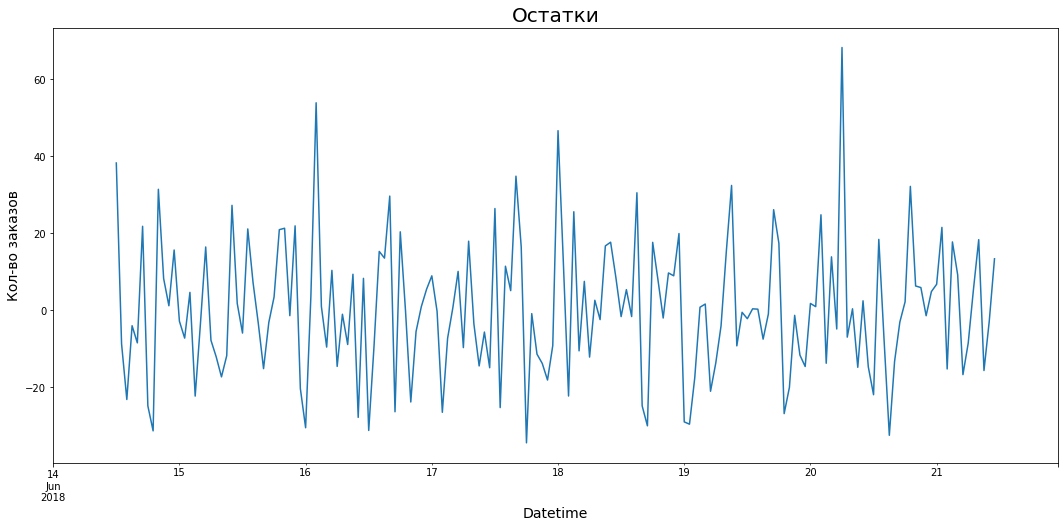

In [8]:
taxi_decomposed_month = seasonal_decompose(taxi['2018-06-14':'2018-06-21'])
taxi_decomposed_month.trend.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Тренд', fontsize=20)
plt.show()
taxi_decomposed_month.seasonal.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Сезонность', fontsize=20)
plt.show()
taxi_decomposed_month.resid.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Остатки', fontsize=20)
plt.show()

**Выводы:**
* Общий тренд говорит о том, что количество заказов такси со временем только растет. За весь период ежедневное количество заказов выросло примерно в три раза.
* Более детальное рассмотрение тренда (на уровне недели) показывает, что пики заказов приходятся на субботу и понедельник. Также можно наблюдать высокую активность в середине недели - среда-четверг. В воскресенье такси в аэропортах берут меньше всего.
* Графики сезонности говорят о том, что наибольшее количество заказов такси приходится на ночное время, а наименьшее - в утреннее время.
* В целом по графикам видно, что количество заказов такси **зависит** от месяца, дня недели, дня месяца, часа. Поэтому далее создадим функцию, которая добавит в датасет эти календарные признаки.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [10]:
taxi_amp = make_features(taxi, 30, 50)
taxi_amp = taxi_amp.dropna()
display(taxi_amp.head())
taxi_amp.info()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,5,2,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,62.82
2018-03-03 03:00:00,64,3,5,3,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,66.00,60.84
2018-03-03 04:00:00,44,3,5,4,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,113.00,60.42
2018-03-03 05:00:00,15,3,5,5,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.00,59.88
2018-03-03 06:00:00,9,3,5,6,15.00,44.00,64.00,25.00,108.00,163.00,72.00,119.00,101.00,93.00,49.00,89.00,83.00,82.00,59.00,44.00,45.00,36.00,91.00,54.00,45.00,46.00,7.00,11.00,11.00,20.00,64.00,75.00,120.00,90.00,58.86


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4366 entries, 2018-03-03 02:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4366 non-null   int64  
 1   month         4366 non-null   int64  
 2   dayofweek     4366 non-null   int64  
 3   hour          4366 non-null   int64  
 4   lag_1         4366 non-null   float64
 5   lag_2         4366 non-null   float64
 6   lag_3         4366 non-null   float64
 7   lag_4         4366 non-null   float64
 8   lag_5         4366 non-null   float64
 9   lag_6         4366 non-null   float64
 10  lag_7         4366 non-null   float64
 11  lag_8         4366 non-null   float64
 12  lag_9         4366 non-null   float64
 13  lag_10        4366 non-null   float64
 14  lag_11        4366 non-null   float64
 15  lag_12        4366 non-null   float64
 16  lag_13        4366 non-null   float64
 17  lag_14        4366 non-null

## Обучение моделей

Разделим датасет на выборку для обучения и тестовую выборку, выделим целевой признак.

In [11]:
train, test = train_test_split(taxi_amp, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print('Обучающая выборка, признаки', features_train.shape)
print('Обучающая выборка, целевой признак', target_train.shape)
print('Тестовая выборка, признаки', features_test.shape)
print('Тестовая выборка, целевой признак', target_test.shape)

Обучающая выборка, признаки (3929, 34)
Обучающая выборка, целевой признак (3929,)
Тестовая выборка, признаки (437, 34)
Тестовая выборка, целевой признак (437,)


Также создадим кросс-валидатор для моделей

In [12]:
# n_splits посчитаем по следующей формуле, 0.1 - размер тестовой выборки
n_splits = int((1//0.1)-1)

tscv = TimeSeriesSplit(n_splits=n_splits)

print('n_splits =', n_splits)

n_splits = 8


Обучим разные модели с различными гиперпараметрами. Гиперпараметры подберем при помощи GridSearchCV.

### LGBMRegressor

In [13]:
%%time

lgbm_model = LGBMRegressor(boosting_type='gbdt', random_state=3208)
parameters = {'learning_rate': [0.05, 0.1],
              'n_estimators': [20, 40, 60],
              'num_leaves': [31, 41, 51] }

gridsearch_lgbm_model = GridSearchCV(lgbm_model, parameters, cv=tscv, scoring='neg_mean_squared_error')
gridsearch_lgbm_model.fit(features_train, target_train)

lgbm_model = gridsearch_lgbm_model.best_estimator_
lgbm_rmse = np.sqrt(-1 * gridsearch_lgbm_model.best_score_)

print('Модель типа LGBMRegressor')
print('rmse:', lgbm_rmse)
gridsearch_lgbm_model.best_params_

Модель типа LGBMRegressor
rmse: 24.61035948676954
CPU times: total: 27.4 s
Wall time: 8.53 s


{'learning_rate': 0.1, 'n_estimators': 60, 'num_leaves': 51}

### CatBoostRegressor

In [14]:
%%time

cbr_model = CatBoostRegressor(random_seed=3208, loss_function='RMSE', silent=True)

parameters = {'learning_rate': [0.05, 0.1],
              'iterations': [20, 40, 60],
              'depth': [i for i in range(2, 11)]}

gridsearch_cbr_model = GridSearchCV(cbr_model, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0)
gridsearch_cbr_model.fit(features_train, target_train)

cbr_model = gridsearch_cbr_model.best_estimator_
cbr_rmse = np.sqrt(-1 * gridsearch_cbr_model.best_score_)

print('Модель типа CatBoostRegressor')
print('rmse:', cbr_rmse)
gridsearch_cbr_model.best_params_

Модель типа CatBoostRegressor
rmse: 25.080564339077615
CPU times: total: 12min 16s
Wall time: 3min 55s


{'depth': 7, 'iterations': 60, 'learning_rate': 0.1}

### RandomForestRegressor

In [15]:
%%time

forest_model = RandomForestRegressor(random_state=3208)

parameters = {'n_estimators': [e for e in range(40, 71, 10)],
              'max_depth': [i for i in range(5, 11)]}

gridsearch_forest_model = GridSearchCV(forest_model, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0)
gridsearch_forest_model.fit(features_train, target_train)

forest_model = gridsearch_forest_model.best_estimator_
forest_rmse = np.sqrt(-1 * gridsearch_forest_model.best_score_)

print('Модель типа RandomForestRegressor')
print('rmse:', forest_rmse)
gridsearch_forest_model.best_params_

Модель типа RandomForestRegressor
rmse: 25.167176426168908
CPU times: total: 3min
Wall time: 3min 4s


{'max_depth': 10, 'n_estimators': 70}

In [16]:
models = pd.Series(['LGBMRegressor', 'CatBoostRegressor', 'RandomForestRegressor'])
rmses = pd.DataFrame([lgbm_rmse, cbr_rmse, forest_rmse], index=models, columns=['RMSE'])
rmses

,RMSE
LGBMRegressor,24.61
CatBoostRegressor,25.08
RandomForestRegressor,25.17


**Выводы**
* Модель типа LGBMRegressor с гиперпараметрами learning_rate=0.1, n_estimators=60, num_leaves=51 показывает RMSE на кросс-валидации: 24.61.
* Модель типа CatBoostRegressor с гиперпараметрами learning_rate=0.1, depth=7, iterations=60 показывает RMSE на кросс-валидации: 25.08.
* Модель типа RandomForestRegressor с гиперпараметрами max_depth=10, n_estimators=70 показывает RMSE на кросс-валидации: 25.17.

## Тестирование моделей

Протестируем полученные модели. Измерим RMSE моделей на тестовой выборке.

In [17]:
preds = []
for model, name in zip([lgbm_model, cbr_model, forest_model], ['lgbm_model', 'cbr_model', 'forest_model']):
    predictions = model.predict(features_test)
    preds.append(predictions)
    rmse_test = np.sqrt(mean_squared_error(target_test, predictions))
    print(f'Модель {name}, RMSE на тестовой выборке: {round(rmse_test, 2)}')

Модель lgbm_model, RMSE на тестовой выборке: 42.65
Модель cbr_model, RMSE на тестовой выборке: 47.92
Модель forest_model, RMSE на тестовой выборке: 43.53


In [18]:
preds_table = pd.DataFrame(preds)
preds_table = preds_table.transpose()
preds_table = preds_table.set_index(target_test.index).join(target_test)
preds_table.columns = (['предсказания lgbm_model', 'предсказания cbr_model', 'предсказания forest_model', 'тестовая выборка'])

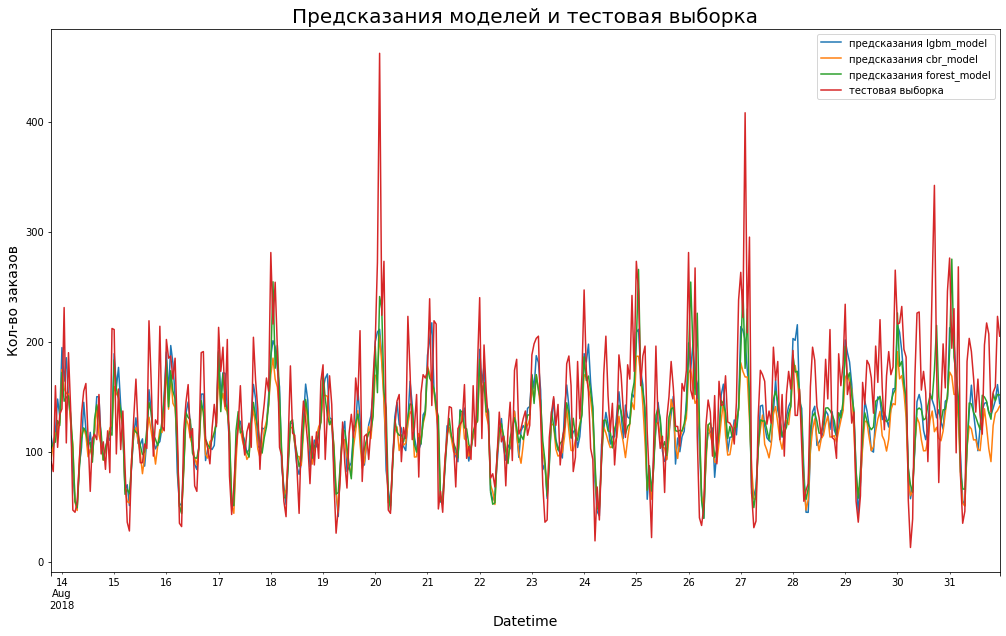

In [19]:
preds_table.plot(figsize=(17, 10))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Предсказания моделей и тестовая выборка', fontsize=20)
plt.show()

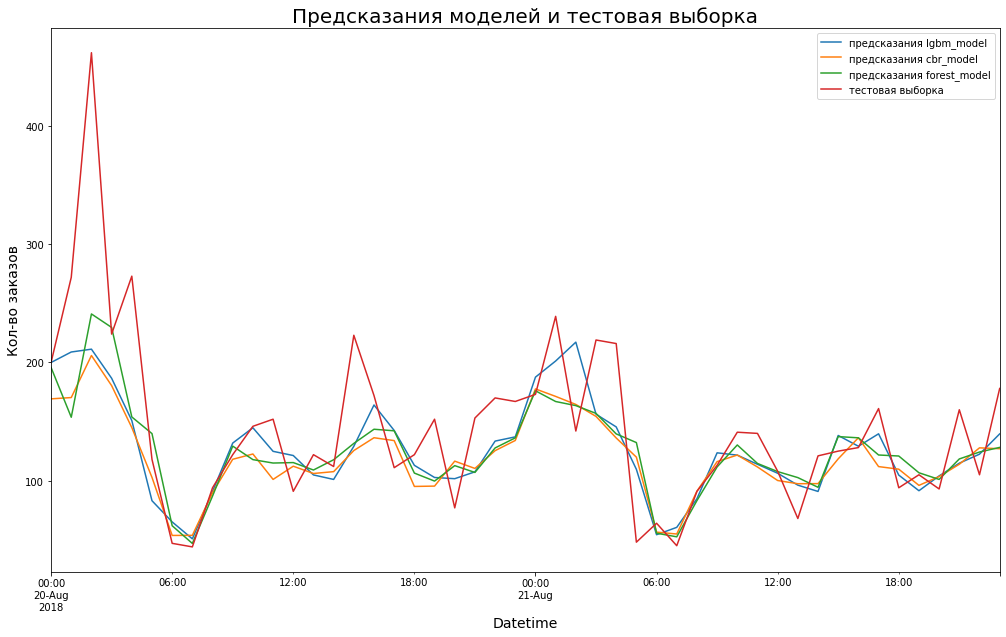

In [20]:
preds_table['2018-08-20':'2018-08-21'].plot(figsize=(17, 10))
plt.ylabel('Кол-во заказов', fontsize=14)
plt.xlabel('Datetime', fontsize=14)
plt.title('Предсказания моделей и тестовая выборка', fontsize=20)
plt.show()

Все модели показывают на тестовой выборке RMSE меньше 48 (что соответствует требованиям заказчика). Но модель типа LGBMRegressor демонстрирует наилучшие результаты (42), её следует использовать заказчику.

Также по графикам видно, что модели LGBMRegressor и RandomForestRegressor дают результаты, наиболее близкие к тестовой выборке.

## Общий вывод

Для компании агрегатора такси нужно было построить модель для предсказания количества заказов такси на следующий час, со значением метрики *RMSE* на тестовой выборке не больше 48.

На первом этапе данные были загружены и проанализированы. Данные содержат только один признак, количество заказов, тип - integer. Пропусков в данных нет, судя по медианному и среднему значению, распределение стремится к нормальному. Индекс проверен на монотонность, шаг по времени в индексе - 10 минут. Данные были ресемплированы по одному часу.

Далее был выполнен анализ данных. Построены графики по тренду, сезонности и остатку - по всем данным и за небольшие периоды. По результатам были сделаны следующие выводы:
* Общий тренд говорит о том, что количество заказов такси со временем только растет. За весь период ежедневное количество заказов выросло примерно в три раза.
* Более детальное рассмотрение тренда (на уровне недели) показывает, что пики заказов приходятся на субботу и понедельник. Также можно наблюдать высокую активность в середине недели - среда-четверг. В воскресенье такси в аэропортах берут меньше всего.
* Графики сезонности говорят о том, что наибольшее количество заказов такси приходится на ночное время, а наименьшее - в утреннее время.

Поскольку быо выяснено, что количество заказов такси **зависит** от месяца, дня недели, дня месяца, часа, далее была создана функция для добавления в датасет этих календарных признаков, а также были добавлены скользящие и отстающие значения.

Далее датасет был разделен на выборку для обучения и тестовую выборку, выделен целевой признак. Обучены разные модели с различными гиперпараметрами. Гиперпараметры были подобраны при помощи GridSearchCV. Результаты:
* Модель типа LGBMRegressor с гиперпараметрами learning_rate=0.1, n_estimators=60, num_leaves=51 показывает RMSE на кросс-валидации: 24.61.
* Модель типа CatBoostRegressor с гиперпараметрами learning_rate=0.1, depth=7, iterations=60 показывает RMSE на кросс-валидации: 25.08.
* Модель типа RandomForestRegressor с гиперпараметрами max_depth=10, n_estimators=70 показывает RMSE на кросс-валидации: 25.17.

Полученные модели были протестированы, метрика RMSE была измерена на тестовой выборке. Все модели показали на тестовой выборке RMSE меньше 48 (что соответствует требованиям заказчика). Но **модель типа LGBMRegressor продемонстировала наилучшие результаты (42), её следует использовать заказчику**.